<a href="https://colab.research.google.com/github/skbetz54/MLB_Statcast_Project/blob/main/Statcast_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Statcast - EDA**

The purpose of this notebook is to perform some simple Exploratory Data Analysis to assess our dataset and understand it better. We will be doing some of the steps from the "Statcast - Data Cleaning" notebook to capture some of the categorical variables.

In [ ]:
import pandas as pd
#raw github file where data is stored
url = "https://raw.githubusercontent.com/skbetz54/MLB_Statcast_Project/main/Data/baltimore_2019.csv"

df = pd.read_csv(url, header=0)

# Dropping deprecated columns that hold no relevant information
df = df.drop(columns=['spin_rate_deprecated','break_angle_deprecated','break_length_deprecated','umpire','pitcher.1','fielder_2.1','fielder_3','fielder_4','fielder_5','fielder_6',
              'fielder_7','fielder_8','fielder_9', 'tfs_deprecated','tfs_zulu_deprecated', 'fielder_2','post_away_score','post_home_score','spin_dir',
              "of_fielding_alignment","if_fielding_alignment","post_fld_score","post_bat_score","fld_score","bat_score","on_1b","on_2b","on_3b","game_year","home_team","away_team"])

# Specifying the various df['events'] occurrences which will remain in the dataframe
events_types = ['single','double','triple','home_run','strikeout','field_out','field_error','fielders_choice_out','force_out','sac_bunt','grounded_into_double_play',
                'strikeout_double_play','sac_fly','double_play','fielders_choice','sac_fly_double_play','other_out']
# Specifying the df['events'] occurrences which will be called a hit
hit_types = ['single','double','triple','home_run']

# deleting rows in which df['events'] or df['pitch_type'] are null, since they are important for analysis (i.e. the middle of an at bat, so no "event" has occurred)
df = df[df.events.notnull()]
df = df[df.pitch_type.notnull()]

for i in df.index:
  if df['events'][i] in events_types:
    continue
  else:
    df.drop(labels= i, inplace = True, errors = 'ignore')

df = df.reset_index()
del df['index']

# Creating a "opp_hand" variable to determine if the batter and pitcher use the same hand
# 0 means the both batter and pitcher are left (right) handed, 1 means they are opposite.

handval = [0 if df['stand'][i] == df['p_throws'][i] else 1 for i in df.index]

df['opp_hand'] = handval

In [ ]:
# Using sklearn.OneHotEncoder to change the "pitch_type" categorical variable to a workable format
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')

#Fitting the encoder to our "pitch_type" variable and creating a dataframe
enc_df = pd.DataFrame(enc.fit_transform(df[['pitch_type']]).toarray())
a = list(enc.get_feature_names())
enc_df.columns = a

#combining the encoded dataframe back into the original
df = df.join(enc_df)

In [ ]:
# Creating our target variable, "HitClf", which will be 1 if the outcome is a hit and 0 otherwise
hitval = [1 if df['events'][i] in hit_types else 0 for i in df.index]

df['HitClf'] = hitval

## **Feature Comparison Plots**



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

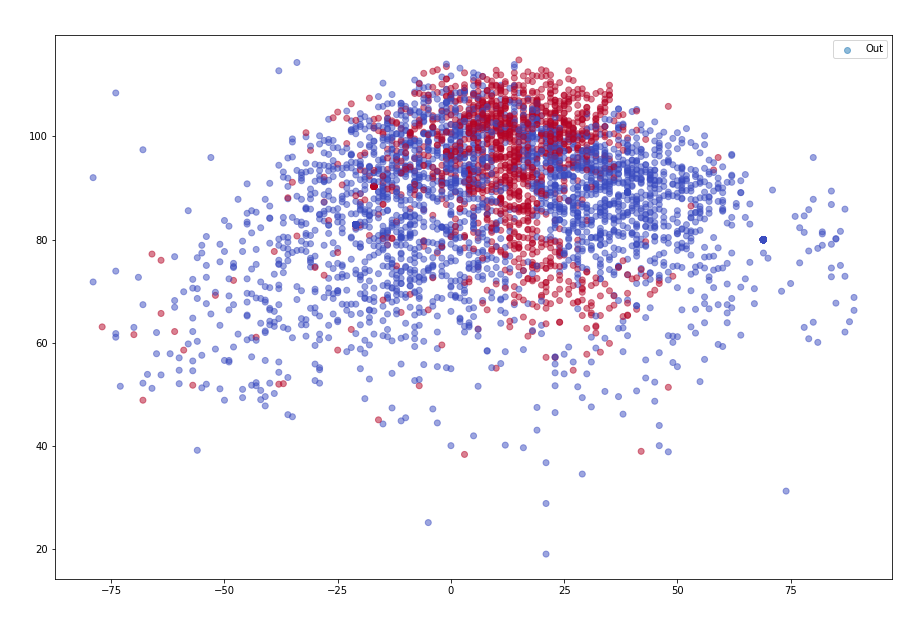

In [ ]:
# Scatterplot of two popular statistics, launch_angle and launch_speed
from google.colab import files
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.scatter(x = df['launch_angle'], y = df['launch_speed'], alpha = 0.5, c = df['HitClf'], cmap = 'coolwarm')
plt.title("Launch Angle vs Launch Speed - Hits and Outs", fontsize = 28, color = 'white')
plt.xlabel("Launch-angle (degrees)", fontsize = 18, color = 'white')
plt.ylabel("Launch Speed (MPH)", fontsize = 18, color = 'white')
plt.legend(['Out','Hit'])
plt.savefig('anglevsspeed.png')
files.download('anglevsspeed.png')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

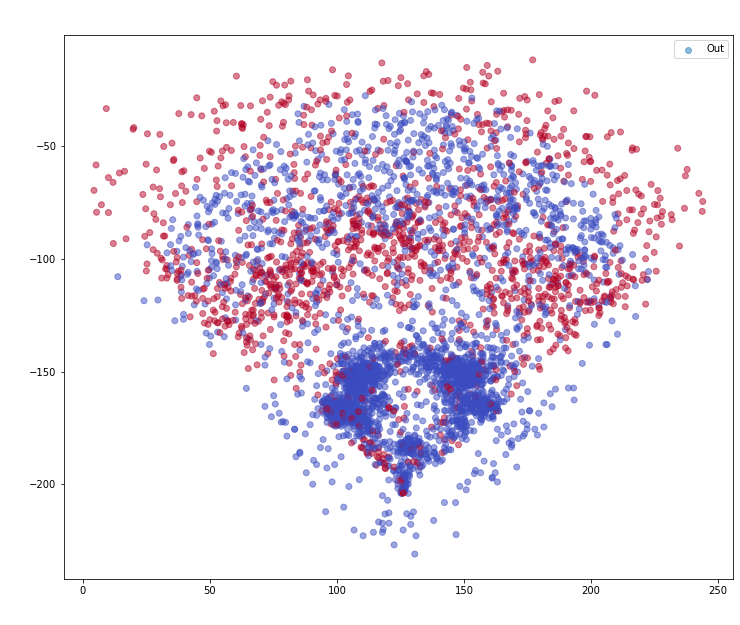

In [ ]:
# Creating a map of the baseball field, again plotted with hits and outs
plt.figure(figsize=(12,10))
plt.scatter(x = df['hc_x'], y = (df['hc_y']*-1), alpha = 0.5, c = df['HitClf'], cmap = 'coolwarm')
plt.title("Batted Ball Coordinates - Hits and Outs", fontsize = 28, color = 'white')
plt.xlabel("x-coordinate", fontsize = 18, color = 'white')
plt.ylabel("y-coordinate", fontsize = 18, color = 'white')
plt.legend(['Out', 'Hit'])

plt.savefig('hitmap.png')
files.download('hitmap.png')
plt.show()

## **Pitch Type vs. Outs and Hits**

In [ ]:
# 
# Creating list of different pitch types a pitcher threw all season
pitches = list(df['pitch_type'].unique())

#Creating empty lists to add hit/out counts to in step below
import numpy as np
hits = list(np.zeros(len(pitches)))
outs = list(np.zeros(len(pitches)))

# Nested for loop to count the occurrences of pitch types, and assigning them as either a 'hit' or 'out' for graphical purposes
for index, pitch in enumerate(pitches):
  for i in df.index:
    if df['pitch_type'][i] == pitch and df['HitClf'][i] == 0:
      outs[index] += 1
    elif df['pitch_type'][i] == pitch and df['HitClf'][i] == 1:
      hits[index] += 1
    else:
      continue

#Calculate the batting averages (on batted balls) for each pitch
ratios = [hits[i]/outs[i] for i, num in enumerate(pitches)]
ratios_mapped = map(lambda n: "%.3f" % n, ratios)
ratios = list(ratios_mapped)

#Pitch names for reference
pitches_names = ['4seam','KnuckleCurve','Cutter','Changeup','2seam','Slider','Curve','Splitter','Sinker','Forkball']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

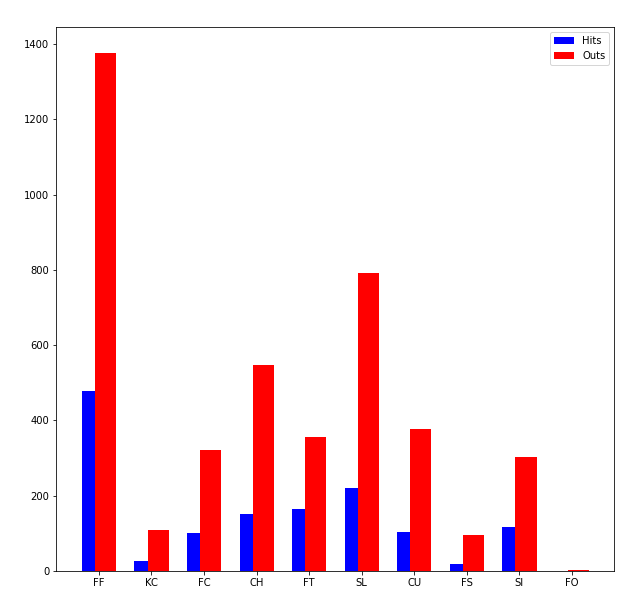

+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|   FF  |   KC  |   FC  |   CH  |   FT  |   SL  |   CU  |   FS  |   SI  |   FO  |
+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| 0.347 | 0.241 | 0.315 | 0.276 | 0.463 | 0.279 | 0.274 | 0.191 | 0.386 | 0.000 |
+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+


In [ ]:
# Create plot of hits vs. outs for each individual pitch

width = .5
w = np.arange(1,20,2)
w1 = [x + width for x in w]

plt.figure(figsize =(10,10))
bar1 = plt.bar(w, hits, color = 'blue', label = 'Hits')
bar2 = plt.bar(w1, outs, color = 'red', label = 'Outs')

plt.title("Hits and Outs By Pitch Type (Ratios Below)", fontsize = 17, color = 'white')
plt.xticks(np.arange(1,20,2)+.25, pitches)
plt.xlabel("Pitch Type", fontsize = 12, color = 'white')
plt.ylabel("No. of Occurrences", fontsize = 12, color = 'white')

plt.legend()

plt.savefig('pitch_type_comparison.png')
files.download('pitch_type_comparison.png')
plt.show()

from prettytable import PrettyTable
t = PrettyTable(pitches)
t.add_row(ratios)
print(t)

## **Imbalanced Classes**


In [ ]:
url = "https://raw.githubusercontent.com/skbetz54/MLB_Statcast_Project/main/Data/chicago_2019_cleaned.csv"

dfc = pd.read_csv(url, header=0, index_col=0)
dfc.shape

(5494, 56)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

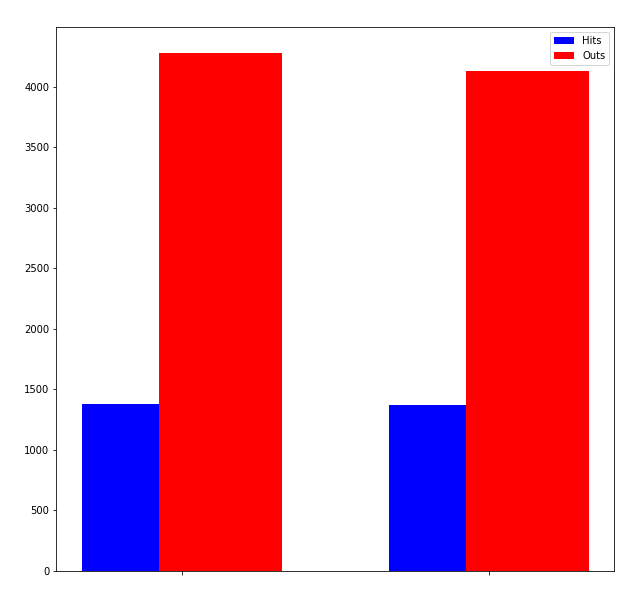

In [ ]:
import numpy as np

a = list(df.HitClf.value_counts())

a1 = list(dfc.HitClf.value_counts())

hits = [a[1], a1[1]]
outs = [a[0],a1[0]]


width = .5
w = np.arange(1,4,2)
w1 = [x + width for x in w]

plt.figure(figsize =(10,10))
bar1 = plt.bar(w, hits, color = 'blue', label = 'Hits')
bar2 = plt.bar(w1, outs, color = 'red', label = 'Outs')

plt.title("Hits and Outs By Data Subset", fontsize = 17, color = 'white')
plt.xticks(np.arange(1,4,2)+.25, ['Strikeouts Included', 'Strikeouts Omitted'], color = 'white')
plt.xlabel("Pitch Type", fontsize = 12, color = 'white')
plt.ylabel("No. of Occurrences", fontsize = 12, color = 'white')

plt.legend()
plt.savefig('strikeouts.png')
files.download('strikeouts.png')
plt.show()